# Modeling Semantic Development with Dynamic Word Embeddings

* [semantic changes](#semantic-changes)
    - semantic
    - syntactic
- [change trend with google word2vec](#gold-google-word2vec)
- [polysemy trend](#polysemy-trend)

In [1]:
import os
from glob import glob
import pickle

import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Sequence
from collections import defaultdict, Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from tqdm import tqdm_notebook as tqdm # convenient progressbar

## semantic-changes
- [Write-utils-functions](#Utils-functions)
- [Link-embeddings-over-time](#Linking-embeddings-over-time)
- [create cdi dataframe](#create-cdi-dataframe)
- [compute-embedding-shifts-df](#compute-embedding-shifts-df)
    - [compute-category-change](#compute-category-change)
    - [compute-lexical-change](#compute-lexical-change)


In [2]:
dicts = pickle.load(open("./childes_data/embeddings-over-time/embeddings-over-time-vocabs-1M-ep25-f15.pickle",'rb'))

vocs: Dict[str, List] = {k: list(v.keys()) for k, v in dicts.items()}
years: List[str] = list(vocs.keys())

# set it to 3000 is to put no constraint
vocab_size = 3000

for key, item in vocs.items():
    print(key, "First 5", item[:5], " Size: ", len(item))
    vocs[key] = item[:vocab_size]
vecs: Dict[str, List] = dict()

for year, d in dicts.items():
    year_vectors = np.array([list(d.values())]).reshape(-1, 100)[:vocab_size]
#     print(year_vectors.shape)
    vecs[year] = year_vectors / np.linalg.norm(year_vectors, axis=-1)[:, np.newaxis]
#     for w in vecs[year] /= norms
#     print(vecs[year])


# sanity check
(vecs['period1']**2).sum(1)

period0 First 5 ['$co$', 'you', 'the', 'be', 'that']  Size:  1656
period1 First 5 ['$co$', 'you', 'be', '$name$', 'the']  Size:  1838
period2 First 5 ['$co$', 'you', 'be', 'the', '$name$']  Size:  1688
period3 First 5 ['$co$', 'you', 'be', 'the', '$name$']  Size:  1720
period4 First 5 ['$co$', 'you', 'be', 'the', 'do']  Size:  1835
period5 First 5 ['$co$', 'you', 'be', 'the', 'do']  Size:  1789
period6 First 5 ['$co$', 'you', 'be', 'do', 'the']  Size:  2035
period7 First 5 ['$co$', 'you', 'be', 'do', 'it']  Size:  1813
period8 First 5 ['$co$', 'you', 'be', 'do', 'the']  Size:  1748
period9 First 5 ['$co$', 'you', 'be', 'the', 'do']  Size:  1866
period10 First 5 ['$co$', 'you', 'do', 'be', 'the']  Size:  2225
period11 First 5 ['$co$', 'you', 'nan', 'do', 'the']  Size:  1689


array([0.9999998 , 1.        , 0.99999994, ..., 0.99999994, 0.99999994,
       1.        ], dtype=float32)

### Utils-functions
- The following functions depends on the following global variables
    - vocs: Dict[str, List[str]]
    - vecs: Dict[str, List[int]]
- Only use period0 to period10
    - remove period11 because each month has fewer words in later periods

In [3]:
years = years[:11]
years

['period0',
 'period1',
 'period2',
 'period3',
 'period4',
 'period5',
 'period6',
 'period7',
 'period8',
 'period9',
 'period10']

In [4]:
import numpy as np
import scipy.sparse as sparse


def neighbors(query : str,
              embs: np.ndarray,
              vocab: list,
              K : int = 3) -> list:
    """returns k nearest neighbors for a query"""
    sims = np.dot(embs[vocab.index(query),],embs.T)
    output = []
    for sim_idx in sims.argsort()[::-1][1:(1+K)]:
        if sims[sim_idx] > 0:
            output.append(vocab[sim_idx])
    return output


def neighbors_per_year(query: str, K=5) -> dict:
    """returns query's neighbors at each period"""
    nns = dict()
    for year, embs in vecs.items():
        nns[year] = neighbors(query, embs, vocs[year], K=K)
    return nns


def build_alignment(year1 : str, year2 : str, vocs, vecs) -> sparse.csr_matrix:
    """
    given two years (keys into vecs and vocs)
    compute a sparse matrix M representing the permutation of word indices from the year1 vecs to the year2 vecs  
    then the rows of v1 will be aligned with the rows of M v2 
    """
   
    all_var1 = vecs[year1].var(1)
    all_var2 = vecs[year2].var(1)

    rows = []
    cols = []

    ivoc2 = {j:i for i,j in enumerate(vocs[year2])}

    for widx1,word in enumerate(vocs[year1]):
        if all_var1[widx1] != 0 and word in set(vocs[year2]):
            widx2 = ivoc2[word]
            if all_var2[widx2] != 0:
                rows.append(widx1)
                cols.append(widx2)

    align = sparse.csr_matrix(([1]*len(rows),(rows,cols)),shape=[len(vocs[year1]),len(vocs[year2])])
    return align


def procrustes(A, B):
    U, _, Vt = np.linalg.svd(B.dot(A.T))
    return U.dot(Vt)


def compute_cos_dist(vec1 : np.array, vec2 : np.array) -> np.array:    
    numerator = (vec1 * vec2).sum(1)
    denominator = np.sqrt((vec1**2).sum(1)) * np.sqrt((vec2**2).sum(1))
    cos_dist = 1 - numerator / (1e-5 + denominator)

    # eliminate words that are zeroed out
    return cos_dist * (vec1.var(1) > 0) * (vec2.var(1) > 0)


def get_neighbor_sims(query : str, neighbor_set : set, vec : np.ndarray, voc : list) -> np.ndarray:
    v_self = vec[voc.index(query),]
    v_neighbors = vec[[voc.index(neighbor) for neighbor in neighbor_set],]
    return np.dot(v_neighbors, v_self)

### Linking-embeddings-over-time
   - project year1's vecs to year2
   - produce `cos_dist` for year2's vocab between year1 and year2
        - fill 0 for words that are not in year1

align (2225, 1656)
vecs_aligned (2225, 100)
vecs_projected (2225, 100)
1656
pre-alignment:  47.8998
pre-projection:  49.50784669827476
after projection:  39.60004445131071


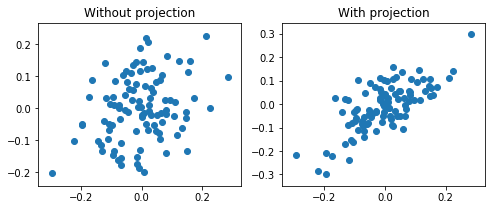

In [5]:
# pick two years to compare
year1 = 'period0'
year2 = 'period10'

align = build_alignment(year2, year1, vocs, vecs)
print("align", align.shape)
vecs_aligned = align.dot(vecs[year1])
print("vecs_aligned", vecs_aligned.shape)

Omega = procrustes(vecs_aligned.T, vecs[year2].T)
vecs_projected = Omega.dot(vecs_aligned.T).T
print("vecs_projected", vecs_projected.shape)

length_of_vocab = min(vecs[year1].shape[0], vecs[year2].shape[0])
print(length_of_vocab)
print('pre-alignment: ',np.linalg.norm(vecs[year2][:length_of_vocab] - vecs[year1]))
print('pre-projection: ',np.linalg.norm(vecs[year2] - vecs_aligned))
print('after projection: ',np.linalg.norm(vecs[year2] - vecs_projected))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=[8,3])

query = 'cat'
vec2_no_project = vecs_aligned[vocs[year2].index(query),]
vec2_projected = vecs_projected[vocs[year2].index(query),]
vec1_query = vecs[year2][vocs[year2].index(query),]

ax1.scatter(vec1_query, vec2_no_project)
ax1.set_title("Without projection")

ax2.scatter(vec1_query, vec2_projected)
ax2.set_title('With projection');

In [6]:
# compute distance
cos_dist = compute_cos_dist(vecs[year2], vecs_projected)
print("cos_dist: ", cos_dist.shape, cos_dist[:10])

cos_dist:  (2225,) [0.23351371 0.17395452 0.15478191 0.16833894 0.21418676 0.18718567
 0.21996719 0.19450843 0.1430391  0.15588189]


### create-cdi-dataframe
- load cdi csv
- create number rows
- merge two dfs

In [9]:
df1 = pd.read_csv("childes_data/data_cdi.csv")
df1 = df1[['item_id', 'definition', 'category', 'lexical_class']]
df1['definition'] = df1['definition'].apply(lambda x: '_'.join(x.split()).lower())
print('shape of CDI data', df1.shape)
print(df1.head(5))

shape of CDI data (680, 4)
  item_id      definition category lexical_class
0  item_1         baa_baa   sounds         other
1  item_2       choo_choo   sounds         other
2  item_3  cockadoodledoo   sounds         other
3  item_4            grrr   sounds         other
4  item_5            meow   sounds         other


In [10]:
num_words_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
             'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 
             'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen', 
             'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 
             'eighty', 'ninety', 'zero', 'hundred', 'thousand', 'million', 
             'billion', 'trillion']
category_list = ['number']*len(num_words_list)
lex_list = ['other']*len(num_words_list)
item_list = ['item_num'+ str(i) for i in range(len(num_words_list))]
df2 = pd.DataFrame({
    'item_id': item_list, 
    'definition': num_words_list,
    'category': category_list,
    'lexical_class': lex_list
})
print('shape of number data', df2.shape)
print(df2.head(5))

shape of number data (33, 4)
     item_id definition category lexical_class
0  item_num0        one   number         other
1  item_num1        two   number         other
2  item_num2      three   number         other
3  item_num3       four   number         other
4  item_num4       five   number         other


In [11]:
df = df1.append(df2)
print('shape of merged data', df.shape)
print(df.head(5))

shape of merged data (713, 4)
  item_id      definition category lexical_class
0  item_1         baa_baa   sounds         other
1  item_2       choo_choo   sounds         other
2  item_3  cockadoodledoo   sounds         other
3  item_4            grrr   sounds         other
4  item_5            meow   sounds         other


### case: Measuring semantic change by near neighbors


In [12]:
query = 'like'
nn_old = neighbors(query, vecs[year1], vocs[year1], K=5)
nn_new = neighbors(query, vecs[year2], vocs[year2], K=5)
print(nn_old)
print(nn_new)

neighbor_set = [word for word in set(nn_old).union(set(nn_new)) 
                if (word in vocs[year1])
                and (word in vocs[year2])
                and (vecs[year1][vocs[year1].index(word)].var() > 0)
                and (vecs[year2][vocs[year2].index(word)].var() > 0)]
print(neighbor_set)

sim_old = get_neighbor_sims(query,neighbor_set,vecs[year1],vocs[year1])
sim_new = get_neighbor_sims(query,neighbor_set,vecs[year2],vocs[year2])
print(sim_old)
print(sim_new)

['remember', 'grape', 'neat', 'will', 'eat']
['construction', 'hum', 'familiar', 'kinda', 'dough']
['neat', 'hum', 'grape', 'will', 'remember', 'eat', 'kinda']
[0.7866426  0.5540005  0.7876152  0.7863038  0.796049   0.7859144
 0.70030975]
[0.60933983 0.6976806  0.5365832  0.5696454  0.48516682 0.28384995
 0.68876183]


### compute-embedding-shifts-df

In [13]:
recompute_embedding_shifts = True
emb_shift_file = os.path.join('.','childes_data','embedding-shifts.csv')

if recompute_embedding_shifts:
    # this may take 5-10 minutes to execute
    neighbor_shift = dict()

    num_neighbors = 25

    for word in tqdm(vocs[year2]):
        if word in vocs[year1]:
            nn_old = neighbors(word, vecs[year1], vocs[year1], K=num_neighbors)
            nn_new = neighbors(word, vecs[year2], vocs[year2], K=num_neighbors)

            neighbor_set = [word for word in set(nn_old).union(set(nn_new)) 
                            if (word in vocs[year1])
                            and (word in vocs[year2])
                            and (vecs[year1][vocs[year1].index(word)].var() > 0)
                            and (vecs[year2][vocs[year2].index(word)].var() > 0)]
        
            s1 = get_neighbor_sims(word, neighbor_set, vecs[year1], vocs[year1])
            s2 = get_neighbor_sims(word, neighbor_set, vecs[year2], vocs[year2])

            dL = compute_cos_dist(s1.reshape(1,-1),s2.reshape(1,-1))[0] / len(neighbor_set)
    
            neighbor_shift[word] = dL
    df_emb_shift = pd.DataFrame({'local':list(neighbor_shift.values()),
                                 'global':[cos_dist[vocs[year2].index(word)] for word in neighbor_shift.keys()]},
                                index=list(neighbor_shift.keys()))
    df_emb_shift.to_csv(emb_shift_file)
else:
    df_emb_shift = pd.read_csv(emb_shift_file,index_col=0)

#### save `embedding_sift` to csv

In [14]:
print(df_emb_shift.shape)
print(df_emb_shift.head())
df_emb_shift.to_csv("./childes_data/embedding_sift.csv")

(1408, 2)
         local    global
$co$  0.000706  0.233514
you   0.000834  0.173955
do    0.000674  0.154782
be    0.001049  0.168339
the   0.001456  0.214187


### compute-semantic-change-function

In [15]:
def compute_semantic_change(df, df_emb_shift, category_name):
    """depends on df and df_emb_shift"""
    global_change_per_category = defaultdict(list)
    local_change_per_category = defaultdict(list)
    for group_name, group_df in df.groupby([category_name]):
    #     print(group_name, group_df.definition.values)
        local_changes = []
        global_changes = []
        for word in group_df.definition.values:
            if word in df_emb_shift.index:
                local_changes.append(df_emb_shift.loc[word]['local'])
                global_changes.append(df_emb_shift.loc[word]['global'])
        local_change_per_category[group_name] = sum(local_changes)/len(local_changes)
        global_change_per_category[group_name] = sum(global_changes)/len(global_changes)
    return local_change_per_category, global_change_per_category

#### compute-category-change

In [16]:
local_change_per_category, global_change_per_category = compute_semantic_change(df, df_emb_shift, 'category')

print("Rank by global change in category group")
for p in sorted(global_change_per_category.items(), key=lambda x: -x[1]):
    print(p)

Rank by global change in category group
('sounds', 0.31850399974811167)
('people', 0.30780773612453033)
('places', 0.29983398661349664)
('outside', 0.29939251446663906)
('vehicles', 0.2911986615993283)
('animals', 0.2821439798096008)
('games_routines', 0.2757861976454593)
('food_drink', 0.2646797803506993)
('furniture_rooms', 0.26225861704435216)
('household', 0.26170745929223904)
('toys', 0.25789376651768386)
('question_words', 0.2567040253095144)
('descriptive_words', 0.2521926761552193)
('locations', 0.25158343478155726)
('action_words', 0.251053650779724)
('pronouns', 0.23653670383457534)
('connecting_words', 0.23062890434073421)
('clothing', 0.22949292243194103)
('body_parts', 0.2293924395382895)
('time_words', 0.22729804495643213)
('quantifiers', 0.21063355006559312)
('helping_verbs', 0.18761596009059622)
('number', 0.1323684625488167)


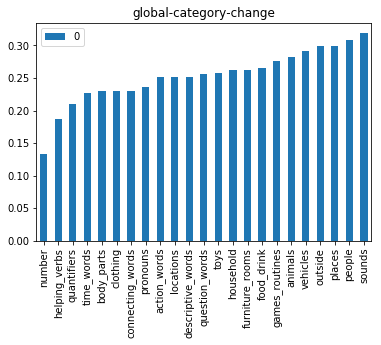

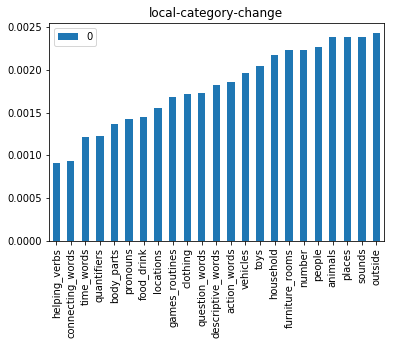

In [18]:
df_category = pd.DataFrame.from_dict(global_change_per_category, orient='index')
df_category.sort_values(0).plot(kind='bar', title="global-category-change")

df_category = pd.DataFrame.from_dict(local_change_per_category, orient='index')
df_category.sort_values(0).plot(kind='bar', title="local-category-change")

### compute-lexical-change

In [19]:
local_change_per_category, global_change_per_category = compute_semantic_change(df, df_emb_shift, 'lexical_class')

print("Rank by global change in {} group".format("lexical_class"))
for p in sorted(global_change_per_category.items(), key=lambda x: -x[1]):
    print(p)

Rank by global change in lexical_class group
('nouns', 0.26466061582141326)
('adjectives', 0.2521926761552193)
('verbs', 0.251053650779724)
('other', 0.24763993201659482)
('function_words', 0.2348813161299686)


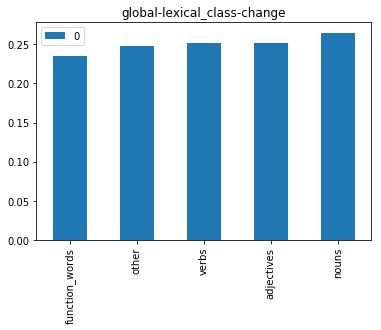

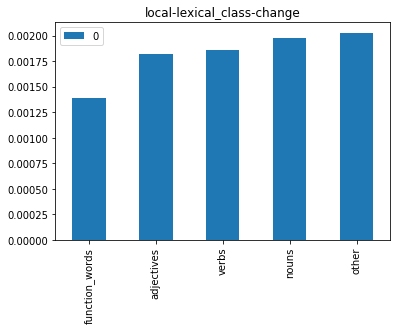

In [20]:
df_category = pd.DataFrame.from_dict(global_change_per_category, orient='index')
df_category.sort_values(0).plot(kind='bar', title="global-lexical_class-change")

df_category = pd.DataFrame.from_dict(local_change_per_category, orient='index')
df_category.sort_values(0).plot(kind='bar', title="local-lexical_class-change")

#### intersection between CDI and df_emb_shift

In [21]:
print("intersection: ", len(set(df['definition'].values).intersection(df_emb_shift.index)))
print(df[df['lexical_class'] == 'other'].head())

intersection:  514
  item_id      definition category lexical_class
0  item_1         baa_baa   sounds         other
1  item_2       choo_choo   sounds         other
2  item_3  cockadoodledoo   sounds         other
3  item_4            grrr   sounds         other
4  item_5            meow   sounds         other


## gold-google-word2vec

In [23]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)

In [24]:
'xxx' in model.vocab

True

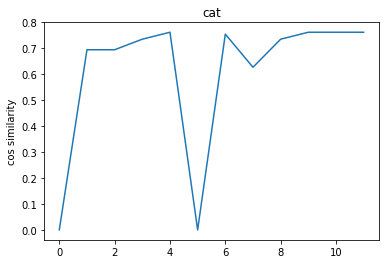

In [25]:
# query = 'cat'
# K_nearest = 20

# word_gold_sim = []
# ms = model.similar_by_word(query, topn=50)
# for period in vocs:
# #     print(ms)
#     sim_scores = [w[1] for w in ms]
#     simMap = {w[0]: w[1] for w in ms}
#     words = set([w[0] for w in ms])
#     avg_sim = sum(sim_scores) / len(sim_scores)
#     neighbor_words = neighbors(query, vecs[period], vocs[period], K=K_nearest)
# #     print(words)
# #     print(neighbor_words)
#     intersection_set = words.intersection(neighbor_words)
#     inter_sims = [simMap[w] for w in intersection_set]
#     if inter_sims:
# #         print(sum(inter_sims) / len(inter_sims))
#         word_gold_sim.append(sum(inter_sims) / len(inter_sims))
#     else:
# #         print(0)
#         word_gold_sim.append(0)
# #     break

# import matplotlib.pyplot as plt
# plt.plot(word_gold_sim)
# plt.ylabel('cos similarity')
# plt.title(query)
# plt.show()


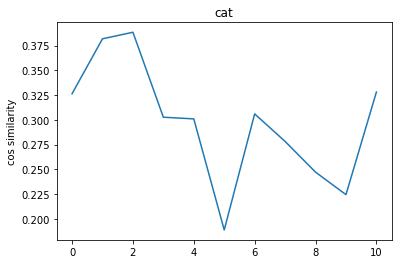

In [35]:
query = 'cat'
K_nearest = 20

word_gold_sim = []

for period in years:

    neighbor_words = neighbors(query, vecs[period], vocs[period], K=K_nearest)
    sims = [model.similarity(query, w) for w in neighbor_words if w in model.vocab]
    if sims:
        word_gold_sim.append(sum(sims) / len(sims))
    else:
        word_gold_sim.append(0)

plt.plot(word_gold_sim)
plt.ylabel('cos similarity')
plt.title(query)
plt.show()


In [47]:
def plot_word_change_over_time(query, K_nearest):
    
    word_gold_sim = []
    
    if query not in model.vocab:
#         print("Word [{}] not in the Google Word2Vec".format(query))
        return word_gold_sim

    for period in years:
        if query not in vocs[period]:
            word_gold_sim.append(0)
            continue
        neighbor_words = neighbors(query, vecs[period], vocs[period], K=K_nearest)
        sims = [model.similarity(query, w) for w in neighbor_words if w in model.vocab]
        if sims:
            word_gold_sim.append(sum(sims) / len(sims))
        else:
            word_gold_sim.append(0)
    return word_gold_sim


In [48]:
def get_w2v_sim(df, group_name):
    from collections import defaultdict
    gold_change_per_category = defaultdict(list)
    for group_name, group_df in df.groupby([group_name]):
        gold_changes = []
        for word in group_df.definition.values:
            gold_sims = plot_word_change_over_time(word, 20)
            if gold_sims:
                gold_changes.append(gold_sims)
            else:
                gold_changes.append([0]*len(years))
        gold_change_per_category[group_name] = np.array(gold_changes)
    return gold_change_per_category

## W2V-SIM-category-change

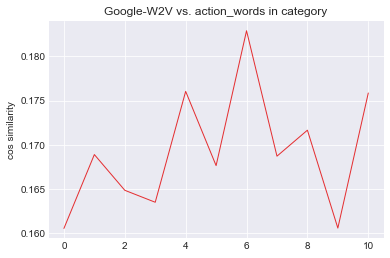

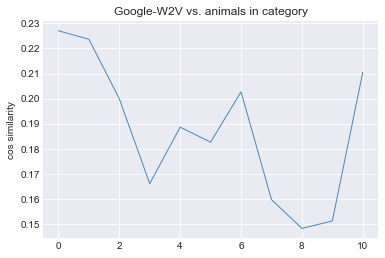

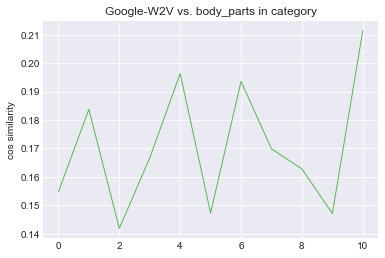

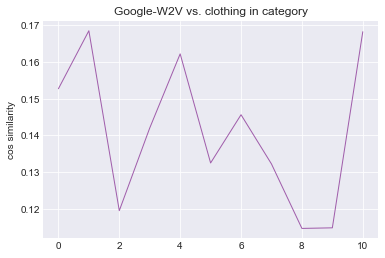

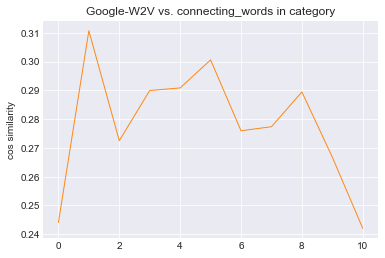

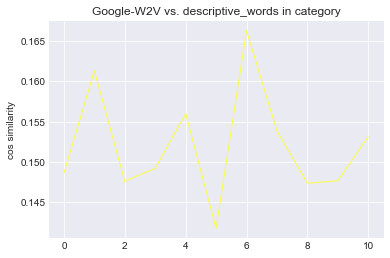

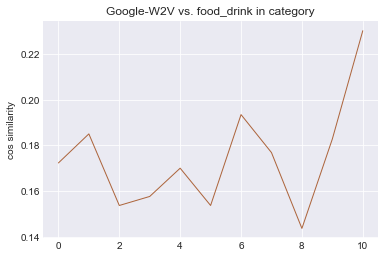

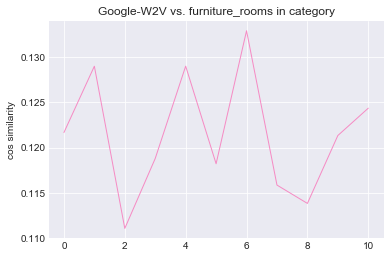

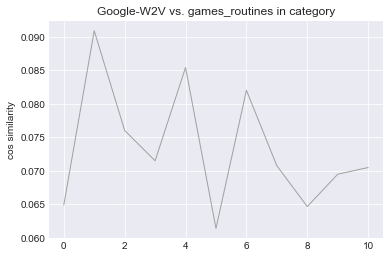

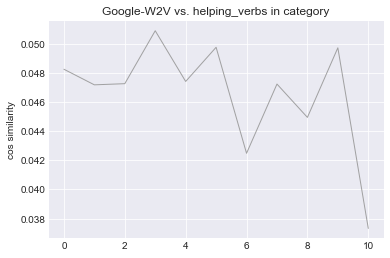

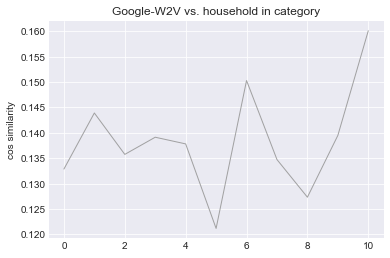

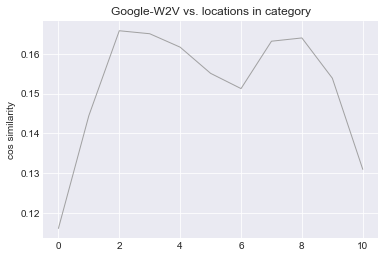

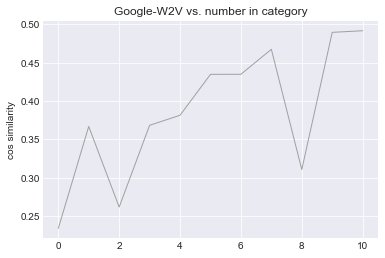

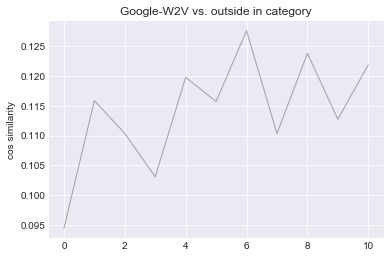

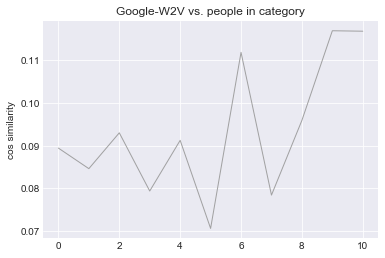

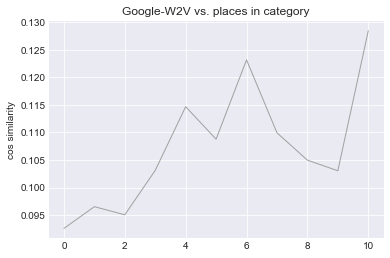

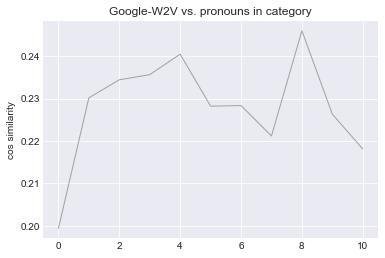

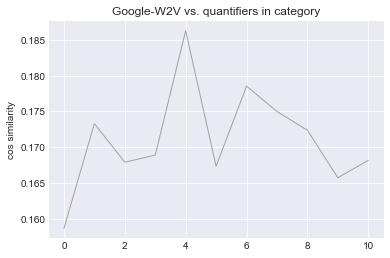

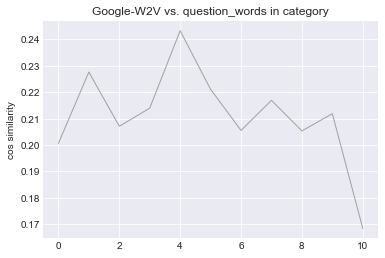

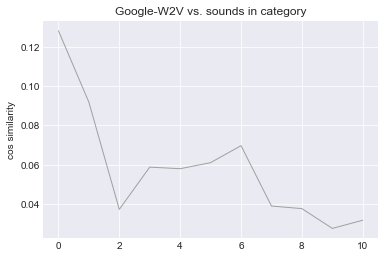

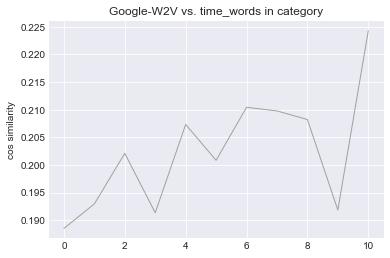

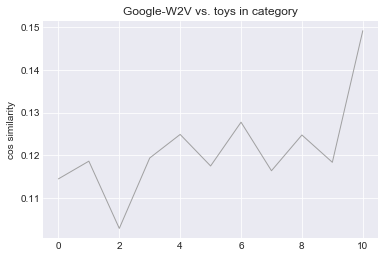

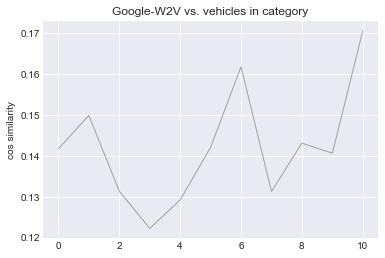

In [116]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

gold_change_per_category = get_w2v_sim(df, 'category')

for idx, action_word in enumerate(gold_change_per_category):
    sims = gold_change_per_category[action_word].mean(0)
    plt.plot(sims, marker='', color=palette(idx), linewidth=1, alpha=0.9, label=action_word)
    plt.ylabel('cos similarity')
    plt.title("Google-W2V vs. {} in category".format(action_word))
    plt.show()

['cat', 'animals', 'nouns']

In [112]:
def save_changes_to_csv(df, category_name):
    """save each word's W2V-SIM changes in all periods to csv"""
    data = []
    gold_change_per_category = get_w2v_sim(df, category_name)
    for group_name, group_df in df.groupby([category_name]):
        for word, sims in zip(group_df.definition.values, gold_change_per_category[group_name]):
            lexical_class = df[df.definition == 'cat'].values[0][-1]
            row = []
            row.append(word)
            row.append(group_name)
            row.append(lexical_class)
            row.extend(sims)
            data.append(row)
    columns = ['word', 'category', 'lexical_class'] + years
    df_change = pd.DataFrame(data, columns=columns)
    df_change.to_csv("childes_data/google-w2v-changes-K-20.csv")


In [113]:
save_changes_to_csv(df, 'category')

In [117]:
gold_change_per_category['action_words'].shape

(103, 11)

In [118]:
df[df['category'] == 'action_words'].shape

(103, 4)

## W2V-SIM changes per lexical class

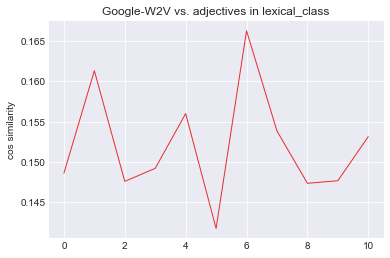

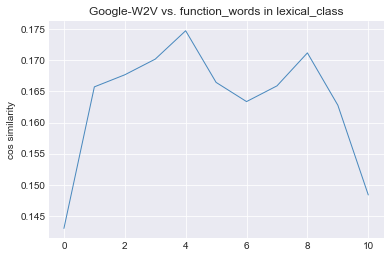

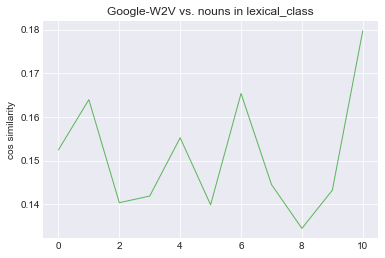

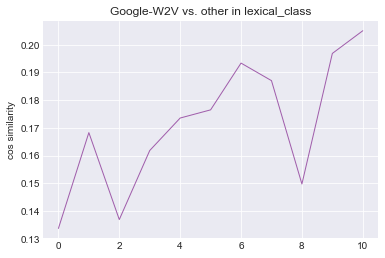

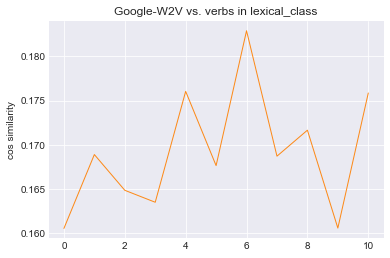

In [98]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

gold_change_per_lexical = get_w2v_sim(df, 'lexical_class')

for idx, action_word in enumerate(gold_change_per_lexical):
    sims = gold_change_per_lexical[action_word].mean(0)
    plt.plot(sims, marker='', color=palette(idx), linewidth=1, alpha=0.9, label=action_word)
    plt.ylabel('cos similarity')
    plt.title("Google-W2V vs. {} in lexical_class".format(action_word))
    plt.show()

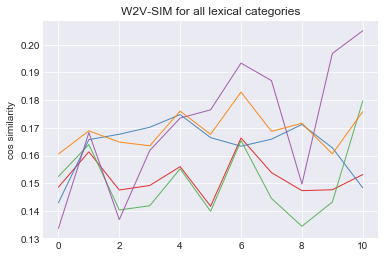

In [99]:
gold_change_per_lexical = get_w2v_sim(df, 'lexical_class')

for idx, action_word in enumerate(gold_change_per_lexical):
    sims = gold_change_per_lexical[action_word].mean(0)
    plt.plot(sims, marker='', color=palette(idx), linewidth=1, alpha=0.9, label=action_word)
plt.ylabel('cos similarity')
plt.title("W2V-SIM for all lexical categories")
plt.show()

## polysemy-trend
- TODO

In [132]:
length = vecs['period0'].shape[0]
a = np.tile(vecs['period0'][0], (length,1))

In [142]:
a[0]

array([-0.11673647, -0.04000604,  0.13675758,  0.17050661,  0.02614844,
        0.11228535,  0.0720541 , -0.17704184, -0.10191578, -0.01742267,
       -0.02914847,  0.01110571,  0.13668133,  0.17764042, -0.06481474,
        0.05909034, -0.07840155,  0.150307  , -0.06921285, -0.05598612,
       -0.07569399,  0.12420619,  0.06980541, -0.05769688,  0.12581939,
        0.01275619,  0.11681123,  0.05796904,  0.06633189,  0.09307271,
        0.00271244, -0.13512924, -0.00966643, -0.16654743, -0.14171614,
       -0.10130001,  0.05784453, -0.06007309,  0.07782722, -0.07821274,
        0.13435845, -0.13635865, -0.00759793,  0.00117392, -0.07988178,
       -0.03086954,  0.00474021, -0.20428447, -0.10815559, -0.05400965,
        0.04949077, -0.00658089, -0.10646494, -0.12420779, -0.20760411,
       -0.01128223,  0.106323  , -0.02861024,  0.17153904,  0.1492883 ,
       -0.10819159, -0.10028837,  0.18055026, -0.0840866 , -0.14227821,
       -0.04515649, -0.16492547,  0.02417676,  0.01662951, -0.16

### compute-sim-between-cdi-words

In [140]:
compute_cos_dist(np.tile(vecs['period0'][0], (length,1)), vecs['period0'])

0.40220875

In [175]:
def compute_distances_per_period(df, period):
    """compute all sims for one period"""
    intersected_words = set(df['definition'].values).intersection(vocs[period])
    voc_cdi = [w for w in vocs[period] if w in intersected_words]
    vecs_cdi = np.array([v for i, v in enumerate(vecs[period]) if vocs[period][i] in intersected_words])
    length = len(intersected_words)
    assert len(voc_cdi) == len(vecs_cdi)
    distances_period = []
    w1_period = []
    w2_period = []
    for i in range(length):
        distances = compute_cos_dist(np.tile(vecs_cdi[i], (length,1)), vecs_cdi)
        distances_period.extend(distances)
        w1_period.extend([voc_cdi[i]]*length)
        w2_period.extend(voc_cdi)
    return distances_period, w1_period, w2_period

In [ ]:
for period in years:
    print(period)
    distances_period, w1_period, w2_period = compute_distances_per_period(df, period)
    df_cdi_product_distance = pd.DataFrame({
        'word1': w1_period,
        'word2': w2_period,
        'cos_sim': distances_period
    })
    df_cdi_product_distance.to_csv("childes_data/cdi_dist/{}_cdi_dist.csv".format(period))

period0
